In [30]:
import tensorflow as tf
import numpy as np
from nn_utils import *
import matplotlib.pyplot as plt
import tensorflow.keras as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalMaxPooling2D
#from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

In [31]:
# For GPU use.

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [32]:
# Load data
train_input,train_label,test_input,test_label = load_dataset(path="dataset/snake_dataset_v3.hdf5")

print("Images train:", train_input.shape)
print("Labels train:", train_label.shape)
print("Images test:", test_input.shape)
print("Labels test:", test_label.shape)

classes = ["copperhead","cottonmouth","watersnake"]

x_train = train_input/255
x_val = test_input/255

Images train: (1215, 192, 192, 3)
Labels train: (1215,)
Images test: (134, 192, 192, 3)
Labels test: (134,)


In [33]:
# prepare the data for the network

x_train = train_input/255
y_train = convert_to_one_hot(train_label,3)
x_val = test_input/255
y_val = convert_to_one_hot(test_label,3)


In [34]:
print(x_train.shape)
print(y_train.shape)

(1215, 192, 192, 3)
(3, 1215)


### Transfer Learning

In [35]:
# Base model 
base_model = InceptionResNetV2(include_top=False,weights='imagenet',input_shape=(192,192,3),pooling="max")

In [36]:
base_model.trainable = False

In [37]:
base_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
conv2d_203 (Conv2D)             (None, 95, 95, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_203 (BatchN (None, 95, 95, 32)   96          conv2d_203[0][0]                 
__________________________________________________________________________________________________
activation_203 (Activation)     (None, 95, 95, 32)   0           batch_normalization_203[0][0]    
________________________________________________________________________________

In [38]:
#pool_layer = K.layers.MaxPooling2D((4,4),strides=(1,1),padding="same")
# fc_layer2 = K.layers.Dense(128,activation=tf.nn.relu)
# fc_layer1 = K.layers.Dense(32,activation=tf.nn.relu)
# out_layer = K.layers.Dense(3,activation=tf.nn.softmax)

# Create output layers for base model
x = base_model.output
x = K.layers.Dense(128,activation=tf.nn.relu)(x)
x = K.layers.Dense(32,activation=tf.nn.relu,kernel_regularizer=K.regularizers.l2(0.001))(x)
predictions = K.layers.Dense(3,activation=tf.nn.softmax)(x)

In [39]:
#model = K.Sequential([base_model,fc_layer1,fc_layer2,out_layer])
model = Model(inputs=base_model.input,outputs=predictions)


In [40]:
rms = K.optimizers.RMSprop(learning_rate=0.001)
adam = K.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)

In [41]:
model.compile(optimizer=adam,loss="categorical_crossentropy",metrics=["accuracy"])

In [42]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
conv2d_203 (Conv2D)             (None, 95, 95, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_203 (BatchN (None, 95, 95, 32)   96          conv2d_203[0][0]                 
__________________________________________________________________________________________________
activation_203 (Activation)     (None, 95, 95, 32)   0           batch_normalization_203[0][0]    
______________________________________________________________________________________________

Total params: 54,537,699
Trainable params: 200,963
Non-trainable params: 54,336,736
__________________________________________________________________________________________________


In [43]:
BATCHS = 15
EPOCHS = 42

In [44]:
history = model.fit(x_train,y_train.T,epochs=EPOCHS,batch_size=BATCHS)

Train on 1215 samples
Epoch 1/42
1215/1215 [==============================] - 11s 9ms/sample - loss: 1.2053 - accuracy: 0.4214
Epoch 2/42
1215/1215 [==============================] - 5s 4ms/sample - loss: 0.9306 - accuracy: 0.5802
Epoch 3/42
1215/1215 [==============================] - 5s 4ms/sample - loss: 0.7980 - accuracy: 0.6626
Epoch 4/42
1215/1215 [==============================] - 5s 4ms/sample - loss: 0.7610 - accuracy: 0.6593
Epoch 5/42
1215/1215 [==============================] - 5s 4ms/sample - loss: 0.7175 - accuracy: 0.7177
Epoch 6/42
1215/1215 [==============================] - 5s 4ms/sample - loss: 0.6683 - accuracy: 0.7391
Epoch 7/42
1215/1215 [==============================] - 5s 4ms/sample - loss: 0.6365 - accuracy: 0.7564
Epoch 8/42
1215/1215 [==============================] - 5s 4ms/sample - loss: 0.6227 - accuracy: 0.7481
Epoch 9/42
1215/1215 [==============================] - 5s 4ms/sample - loss: 0.5891 - accuracy: 0.7852
Epoch 10/42
1215/1215 [==================

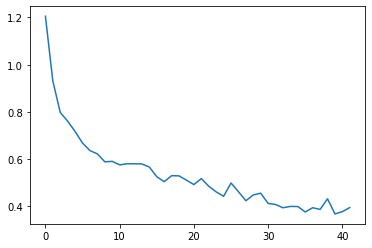

In [45]:
plt.plot(history.history['loss'])

In [113]:
test_loss, test_acc = model.evaluate(x_val, y_val.T,verbose=0)
print("loss: {:3f} - accuracy: {:3f}".format(test_loss,test_acc))

loss: 0.964296 - accuracy: 0.791045


In [47]:
# save model after training external layers.
model.save('custom_InceptionResNetv2.h5') 

In [48]:
predictions = model.predict(x_val)

Predicted Classe: copperhead
Confidence: 98.40%
Correct classe: copperhead


<BarContainer object of 3 artists>

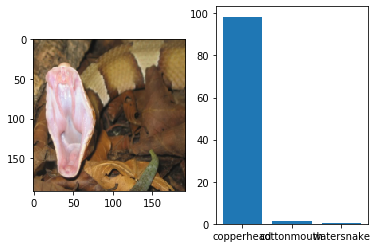

In [53]:
classes = ["copperhead","cottonmouth","watersnake"]

idx = np.random.randint(0,test_input.shape[0])
#plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(test_input[idx])
print("Predicted Classe: {}".format(classes[np.argmax(predictions[idx,:])]))
print("Confidence: {0:.2f}%".format(100*predictions[idx,:].max()))
print("Correct classe: {}".format(classes[np.where(y_val[:,idx]==1)[0][0]]))
plt.subplot(1,2,2)
plt.bar(classes,100*predictions[idx])

In [54]:
for i, layer in enumerate(model.layers):
   print(i, layer.name)

0 input_2
1 conv2d_203
2 batch_normalization_203
3 activation_203
4 conv2d_204
5 batch_normalization_204
6 activation_204
7 conv2d_205
8 batch_normalization_205
9 activation_205
10 max_pooling2d_4
11 conv2d_206
12 batch_normalization_206
13 activation_206
14 conv2d_207
15 batch_normalization_207
16 activation_207
17 max_pooling2d_5
18 conv2d_211
19 batch_normalization_211
20 activation_211
21 conv2d_209
22 conv2d_212
23 batch_normalization_209
24 batch_normalization_212
25 activation_209
26 activation_212
27 average_pooling2d_1
28 conv2d_208
29 conv2d_210
30 conv2d_213
31 conv2d_214
32 batch_normalization_208
33 batch_normalization_210
34 batch_normalization_213
35 batch_normalization_214
36 activation_208
37 activation_210
38 activation_213
39 activation_214
40 mixed_5b
41 conv2d_218
42 batch_normalization_218
43 activation_218
44 conv2d_216
45 conv2d_219
46 batch_normalization_216
47 batch_normalization_219
48 activation_216
49 activation_219
50 conv2d_215
51 conv2d_217
52 conv2d_220

In [55]:
for layer in model.layers[:777]:
   layer.trainable = False
for layer in model.layers[777:781]:
   layer.trainable = True
for layer in model.layers[781:]:
    layer.trainable = False

In [57]:
# recompile the model 
model.compile(optimizer=adam,loss="categorical_crossentropy",metrics=["accuracy"])

In [58]:
#Training of the conv7b layers


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
conv2d_203 (Conv2D)             (None, 95, 95, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_203 (BatchN (None, 95, 95, 32)   96          conv2d_203[0][0]                 
__________________________________________________________________________________________________
activation_203 (Activation)     (None, 95, 95, 32)   0           batch_normalization_203[0][0]    
______________________________________________________________________________________________

Total params: 54,537,699
Trainable params: 3,196,416
Non-trainable params: 51,341,283
__________________________________________________________________________________________________


In [59]:
history_1 = model.fit(x_train,y_train.T,epochs=10,batch_size=BATCHS)

Train on 1215 samples
Epoch 1/10
1215/1215 [==============================] - 11s 9ms/sample - loss: 0.6769 - accuracy: 0.7901
Epoch 2/10
1215/1215 [==============================] - 5s 4ms/sample - loss: 0.2500 - accuracy: 0.9210
Epoch 3/10
1215/1215 [==============================] - 5s 4ms/sample - loss: 0.1968 - accuracy: 0.9547
Epoch 4/10
1215/1215 [==============================] - 5s 4ms/sample - loss: 0.1413 - accuracy: 0.9588
Epoch 5/10
1215/1215 [==============================] - 5s 4ms/sample - loss: 0.1169 - accuracy: 0.9728
Epoch 6/10
1215/1215 [==============================] - 5s 4ms/sample - loss: 0.1194 - accuracy: 0.9745
Epoch 7/10
1215/1215 [==============================] - 5s 4ms/sample - loss: 0.0958 - accuracy: 0.9737
Epoch 8/10
1215/1215 [==============================] - 5s 4ms/sample - loss: 0.0802 - accuracy: 0.9852
Epoch 9/10
1215/1215 [==============================] - 5s 4ms/sample - loss: 0.0810 - accuracy: 0.9868
Epoch 10/10
1215/1215 [==================

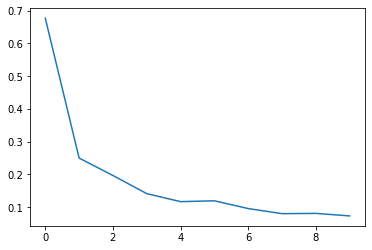

In [61]:
plt.plot(history_1.history['loss'])

In [109]:
test_loss, test_acc = model.evaluate(x_val, y_val.T,verbose=0)
print('Accuracy: %f' %(test_acc))

Accuracy: 0.791045


In [65]:
# save model after training CONV layers.
model.save('custom_InceptionResNetv2.h5')

In [63]:
134/2

67.0

In [66]:
predictions = model.predict(x_val)

Predicted Classe: watersnake
Confidence: 99.93%
Correct classe: watersnake


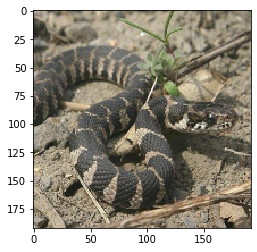

In [110]:
classes = ["copperhead","cottonmouth","watersnake"]
idx = np.random.randint(0,test_input.shape[0])
plt.imshow(test_input[idx])
print("Predicted Classe: {}".format(classes[np.argmax(predictions[idx,:])]))
print("Confidence: {0:.2f}%".format(100*predictions[idx,:].max()))
print("Correct classe: {}".format(classes[np.where(y_val[:,idx]==1)[0][0]]))

In [114]:
# Training deeper layer

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
conv2d_203 (Conv2D)             (None, 95, 95, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_203 (BatchN (None, 95, 95, 32)   96          conv2d_203[0][0]                 
__________________________________________________________________________________________________
activation_203 (Activation)     (None, 95, 95, 32)   0           batch_normalization_203[0][0]    
______________________________________________________________________________________________

dense_9 (Dense)                 (None, 128)          196736      global_max_pooling2d_1[0][0]     
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 32)           4128        dense_9[0][0]                    
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 3)            99          dense_10[0][0]                   
Total params: 54,537,699
Trainable params: 3,196,416
Non-trainable params: 51,341,283
__________________________________________________________________________________________________


In [115]:
for layer in model.layers[:768]:
    layer.trainable = False
for layer in model.layers[768:776]:
    layer.trainable = True
for layer in model.layers[768:776]:
    layer.trainable = False

In [116]:
# recompile the model 
model.compile(optimizer=adam,loss="categorical_crossentropy",metrics=["accuracy"])

In [117]:
history_2 = model.fit(x_train,y_train.T,epochs=10,batch_size=BATCHS)

Train on 1215 samples
Epoch 1/10
1215/1215 [==============================] - 8s 7ms/sample - loss: 0.0698 - accuracy: 0.9909
Epoch 2/10
1215/1215 [==============================] - 5s 4ms/sample - loss: 0.0710 - accuracy: 0.9868
Epoch 3/10
1215/1215 [==============================] - 5s 4ms/sample - loss: 0.0605 - accuracy: 0.9942
Epoch 4/10
1215/1215 [==============================] - 5s 4ms/sample - loss: 0.0722 - accuracy: 0.9893
Epoch 5/10
1215/1215 [==============================] - 5s 4ms/sample - loss: 0.0559 - accuracy: 0.9959
Epoch 6/10
1215/1215 [==============================] - 5s 4ms/sample - loss: 0.0637 - accuracy: 0.9926
Epoch 7/10
1215/1215 [==============================] - 5s 4ms/sample - loss: 0.0752 - accuracy: 0.9885
Epoch 8/10
1215/1215 [==============================] - 5s 4ms/sample - loss: 0.0546 - accuracy: 0.9975
Epoch 9/10
1215/1215 [==============================] - 5s 4ms/sample - loss: 0.0568 - accuracy: 0.9942
Epoch 10/10
1215/1215 [===================

In [118]:
test_loss, test_acc = model.evaluate(x_val, y_val.T,verbose=0)
print('Accuracy: %f' %(test_acc))

Accuracy: 0.738806


Note: loss of accuracy when training the layer 768 to 776

# TEST WITH AN ONLINE IMAGE

In [119]:
from skimage import io, transform

In [120]:
img = io.imread('https://www.ct.gov/deep/lib/deep/wildlife/images/outreach/fact_sheets/watersnake.jpg')
img = transform.resize(img,(192,192))

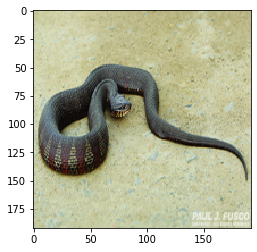

In [121]:
plt.imshow(img)

In [122]:
img = img.reshape((-1,192,192,3))
predicted_snake = model.predict(img,batch_size=1)
print("Predicted Classe: {}".format(classes[np.argmax(predicted_snake)]))
print("Confidence: {0:.2f}%".format(100*predicted_snake.max()))

Predicted Classe: watersnake
Confidence: 99.96%


In [95]:
predicted_snake.T

array([[0.00433536],
       [0.03919868],
       [0.95646596]], dtype=float32)